# IMPORTS

In [1]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D,MaxPool2D, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random as rnd

import os


# Load Dataset
## import data from .npz file

In [2]:

data = np.load("ORL_faces.npz")

# split and scale the data

In [3]:

trainY = data["trainY"]
trainX = data["trainX"]
testY = data["testY"]
testX = data["testX"]


# Scale the data

In [4]:

trainX = trainX/255 # values are between 0 and 255
testX = testX/255

# reshape inputs, encode categories

In [5]:

trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainX = trainX.reshape(240,112,92,1)
testX = testX.reshape(160,112,92,1)
trainY.shape,trainX.shape,"||||",testY.shape,testX.shape

((240, 20), (240, 112, 92, 1), '||||', (160, 20), (160, 112, 92, 1))

# verify correct shaping and preview data

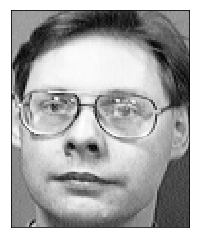

In [6]:
index = rnd.randint(0,testX.shape[0]-1)
plt.imshow(testX[index].reshape((112,92)), cmap="Greys_r")
plt.xticks([])
plt.yticks([])
plt.show()

# construct the model

In [15]:
import keras_tuner as kt

In [108]:
def buildModel(hp):
  model = Sequential()
  kern = hp.Choice("kernel_size", [3,4,5])

  model.add(Conv2D(
    hp.Choice("units",[8,16,32]), 
    kernel_size=hp.Choice("kernel_size", [3,4,5]),
    input_shape=(112,92,1), 
    activation="relu"))
  model.add(Dropout(hp.Choice("rate",[.3,.4,.5,.6])))
  model.add(
    MaxPool2D((2,2),strides=(2,2))
    )
  second_layer=hp.Choice("2nd",[True,False])
  if second_layer:
    model.add(Conv2D(
      hp.Choice("units_2nd",[8,16,32]), 
      kernel_size=hp.Choice("kernel_size_2nd", [3,4,5]),
      input_shape=(112,92,1), 
      activation="relu"))
    model.add(Dropout(hp.Choice("2ndrate",[.3,.4,.5,.6])))
    model.add(
     MaxPool2D((2,2),strides=(2,2))
     )
  third_layer=hp.Choice("3rd",[True,False])
  if second_layer and third_layer:
    model.add(Conv2D(
      hp.Choice("units_3rd",[8,16,32]), 
      kernel_size=hp.Choice("kernel_size_3rd", [3,4,5]),
      input_shape=(112,92,1), 
      activation="relu"))
    model.add(Dropout(hp.Choice("3rdrate",[.3,.4,.5,.6])))
    model.add(
     MaxPool2D((2,2),strides=(2,2))
     )


  model.add(Flatten())
  model.add(Dense(20, activation="softmax"))
  model.optimizer = hp.Choice("optimizer",["adam","sgb","rmsprop"])
  model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
  return model


In [109]:
tuner = kt.RandomSearch(
    buildModel,
    objective='val_loss',
    max_trials=10)


In [110]:
tuner.search(trainX,trainY,epochs=5,validation_data=(testX,testY))

Trial 10 Complete [00h 00m 06s]
val_loss: 1.6646430492401123

Best val_loss So Far: 1.131946325302124
Total elapsed time: 00h 01m 14s
INFO:tensorflow:Oracle triggered exit


In [111]:
best_model = tuner.get_best_models()[0]

In [112]:
best_model.fit(trainX,trainY,epochs=100,validation_data=(testX,testY),callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
results = best_model.history.history

Epoch 1/100
8/8 [==============================] - 3s 217ms/step - loss: 0.1695 - accuracy: 0.9958 - val_loss: 1.9518 - val_accuracy: 0.3000
Epoch 2/100
8/8 [==============================] - 1s 184ms/step - loss: 0.5243 - accuracy: 0.8750 - val_loss: 0.7703 - val_accuracy: 0.9250
Epoch 3/100
8/8 [==============================] - 2s 189ms/step - loss: 0.0558 - accuracy: 1.0000 - val_loss: 0.6402 - val_accuracy: 0.9312
Epoch 4/100
8/8 [==============================] - 1s 186ms/step - loss: 0.0409 - accuracy: 0.9958 - val_loss: 0.7576 - val_accuracy: 0.7812
Epoch 5/100
8/8 [==============================] - 2s 205ms/step - loss: 0.0361 - accuracy: 0.9958 - val_loss: 0.7341 - val_accuracy: 0.8188
Epoch 6/100
8/8 [==============================] - 2s 199ms/step - loss: 0.0425 - accuracy: 0.9958 - val_loss: 0.5383 - val_accuracy: 0.9187
Epoch 7/100
8/8 [==============================] - 1s 187ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.4104 - val_accuracy: 0.9375
Epoch 8/100
8

In [113]:
best_model.evaluate(testX,testY)

5/5 [==============================] - 0s 25ms/step - loss: 0.4302 - accuracy: 0.9187


[0.4302040636539459, 0.918749988079071]

In [91]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 90, 32)       320       
_________________________________________________________________
dropout (Dropout)            (None, 110, 90, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 45, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 79200)             0         
_________________________________________________________________
dense (Dense)                (None, 20)                1584020   
Total params: 1,584,340
Trainable params: 1,584,340
Non-trainable params: 0
_________________________________________________________________


In [88]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
kernel_size: 3
units: 32
rate: 0.6
2nd: 0
units_2nd: 8
kernel_size_2nd: 4
2ndrate: 0.5
3rd: 1
units_3rd: 32
kernel_size_3rd: 4
3rdrate: 0.5
optimizer: adam
Score: 1.1970207691192627
Trial summary
Hyperparameters:
kernel_size: 5
units: 32
rate: 0.5
2nd: 0
units_2nd: 16
kernel_size_2nd: 4
2ndrate: 0.3
3rd: 1
units_3rd: 8
kernel_size_3rd: 5
3rdrate: 0.3
optimizer: adam
Score: 1.3592747449874878
Trial summary
Hyperparameters:
kernel_size: 5
units: 16
rate: 0.6
2nd: 0
units_2nd: 8
kernel_size_2nd: 4
2ndrate: 0.4
3rd: 0
units_3rd: 32
kernel_size_3rd: 4
3rdrate: 0.3
optimizer: adam
Score: 1.3634045124053955
Trial summary
Hyperparameters:
kernel_size: 5
units: 16
rate: 0.3
2nd: 0
units_2nd: 8
kernel_size_2nd: 5
2ndrate: 0.5
3rd: 0
units_3rd: 16
kernel_size_3rd: 3
3rdrate: 0.6
optimizer: adam
Score: 1.375335693359375
Trial summary
Hyperparameters:
kerne

Misidentified faces


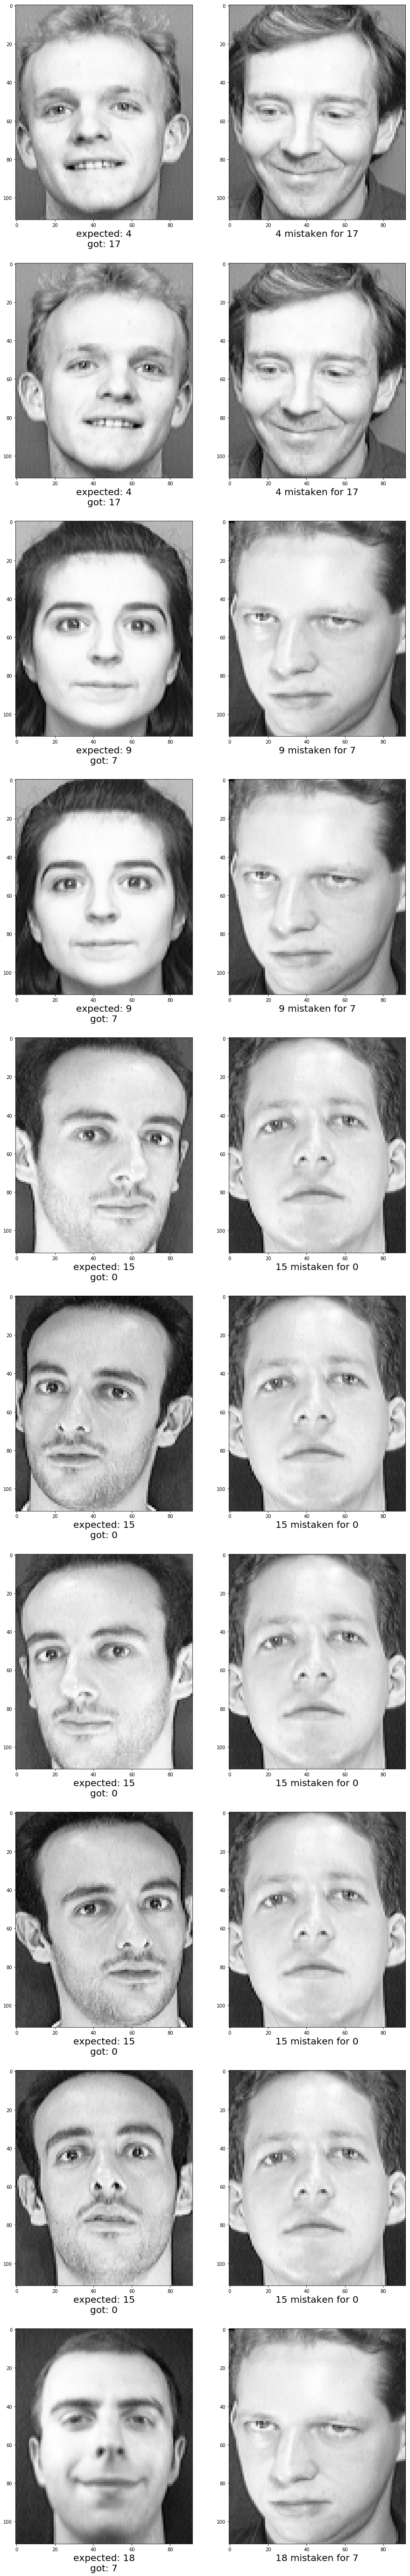

In [119]:
#save the model
plt.figure(figsize=(15,100))
layer=1
print("Misidentified faces")
for n, face in enumerate(testX):
    if layer >20:
        break
    pred = best_model.predict(face.reshape(1,112,92,1)).argmax()
    if pred != testY[n].argmax():
        plt.subplot(10,2,layer,autoscale_on=True)
        layer+=1
        plt.imshow(face.reshape((face.shape[0],face.shape[1])), cmap = "Greys_r")
        plt.xlabel(f"expected: {testY[n].argmax()}\ngot: {pred}",fontsize=20)
        plt.subplot(10,2,layer,autoscale_on=True)
        layer+=1
        plt.imshow(testX[pred].reshape((testX[pred].shape[0],testX[pred].shape[1])), cmap = "Greys_r")
        plt.xlabel(f"{testY[n].argmax()} mistaken for {pred}",fontsize=20)


plt.show()

In [114]:
type(best_model)

keras.engine.sequential.Sequential

In [107]:
results

{}